# Data Scientist Professional Practical Exam Submission

# Business Objective

The recipe business Tasty Bytes puts a recipe of choice on their website's homepage, and they have found that when there is a popular recipe on the homepage, they get higher web traffic and thus, more subscriptions/revenue etc. The goal of this analysis is to be able to predict which recipes will lead to high traffic, and be able to correctly predict high traffic recipes 80% of the time so they can make better decisions on which recipes to include on their homepage to drive business growth.

In [92]:
# import libraries and the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./recipe2.csv")
print(df.columns)
print(df.dtypes)

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic'],
      dtype='object')
recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object


In [93]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [94]:
df.shape

(947, 8)

## Data Validation and Cleaning

### Servings

In [95]:
df["servings"].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [96]:
# Extracting numerical part and converting to integers
df["servings"] = df["servings"].astype(str)
df['servings'] = df['servings'].str.extract('(\d+)').astype(int)
df["servings"].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

### Category

In [97]:
categorial_vars = ["category", "high_traffic"]
for column in categorial_vars:
    print(df[column].value_counts())

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64
High    574
Name: high_traffic, dtype: int64


Going to need to infuse "Chicken Breast" with "Chicken" since there should only be 10 categories

In [98]:
df.loc[df["category"] == "Chicken Breast", "category"] = "Chicken"

In [99]:
print(df["category"].value_counts())

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64


### Recipe

In [100]:
df["recipe"].describe()

count    947.000000
mean     474.000000
std      273.519652
min        1.000000
25%      237.500000
50%      474.000000
75%      710.500000
max      947.000000
Name: recipe, dtype: float64

Recipe is good since it is already a unique identifier formatted as an integer.

### High Traffic

In [101]:
df["high_traffic"] = df["high_traffic"].fillna("Low")
# Make the variable ordinal
df["high_traffic"] = pd.Categorical(df["high_traffic"], categories = ["High", "Low"], ordered=True)

Here, I filled the N/A values as "Low" to contrast the "High" values, then made it an ordinal categorical variable. Since this is the target variable and it is binary, it will be better for the models to interpret an ordinal variable with two levels.

### Calories, Carbohydrate, Sugar, Protein

In [102]:
df.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

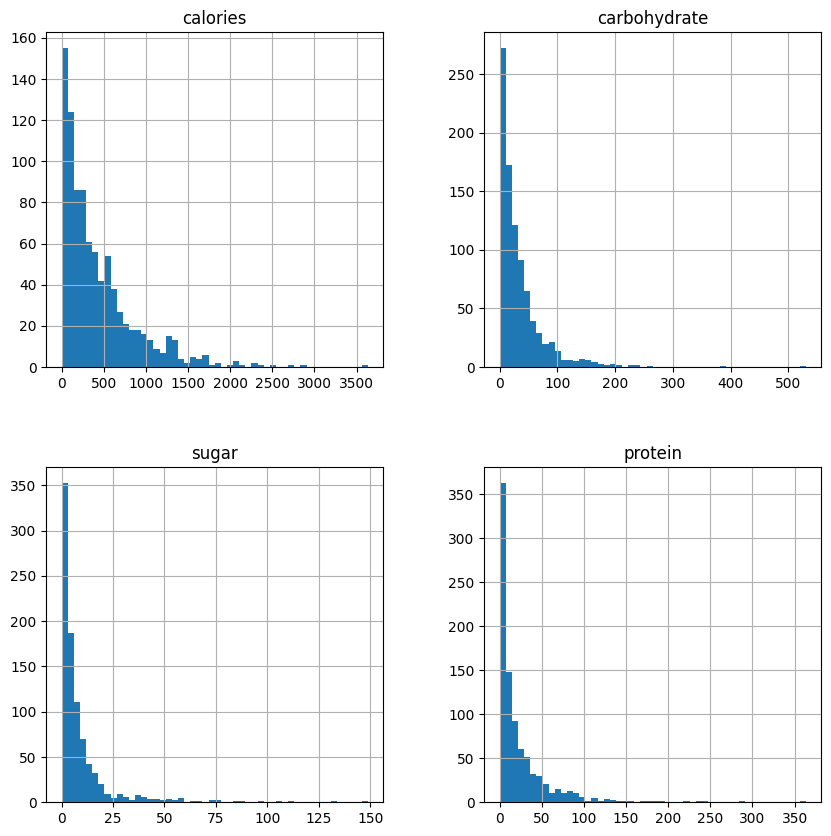

In [103]:
df[['calories', 'carbohydrate', 'sugar', 'protein']].hist(figsize=(10, 10), bins=50)
plt.show()

The distributions of each of the numerical predictors is skewed right, so when we impute missing values we want these distributions to look similar to maintain the accuracy of the predictions.

In [104]:
df["calories"].describe()

count     895.000000
mean      435.939196
std       453.020997
min         0.140000
25%       110.430000
50%       288.550000
75%       597.650000
max      3633.160000
Name: calories, dtype: float64

In [127]:
df["protein"].describe()

count    947.000000
mean      24.149296
std       35.356020
min        0.000000
25%        3.465000
50%       12.120000
75%       28.530000
max      363.360000
Name: protein, dtype: float64

In [105]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Subset data
features = ['calories', 'carbohydrate', 'sugar', 'protein']
data_subset = df[features]

# MICE
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
data_mice_imputed = mice_imputer.fit_transform(data_subset)

df[features] = data_mice_imputed

Here I used MICE imputation, which stands for "Multiple Imputations by Chained Equations" which starts by imputing a value with simple imputation such as mean imputation, then removes one predictor and treats that as the target variable in a regression model. It then repeats this process until stable points are reached, and the goal is to have a value that is based on the other values in its instance.

In [106]:
df["calories"].describe()

count     947.000000
mean      435.939196
std       440.394131
min         0.140000
25%       114.410000
50%       313.530000
75%       576.225000
max      3633.160000
Name: calories, dtype: float64

In [107]:
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

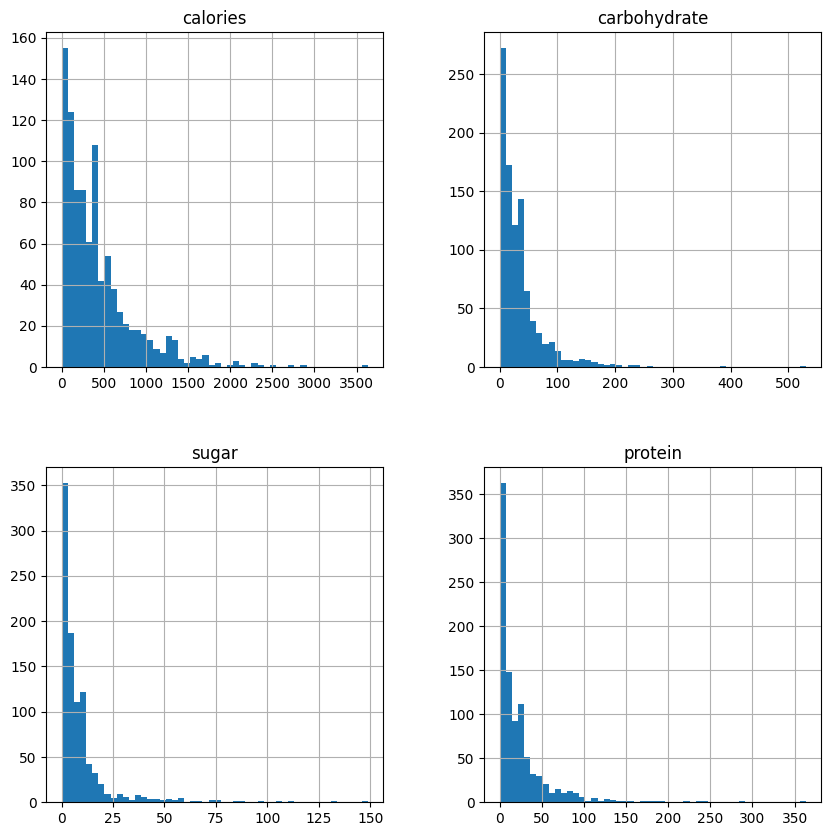

In [108]:
df[['calories', 'carbohydrate', 'sugar', 'protein']].hist(figsize=(10, 10), bins=50)
plt.show()

### Description

Data Validation
This data set has 947 rows, 8 columns. I have validated all variables and I have not made any changes after validation. 
7 of the columns required cleaning, and 1 did not.

recipe: Unique identifier with no missing values, same as the description. No cleaning is needed.

calories: Numeric values between ~0 to 3633 with 52 missing values, MICE imputation was done to ensure better estimation of the missing values than mean imputation.

carbohydrate: numeric values with 52 missing values, just like calories, MICE imputation was done for missing values.

sugar: Numeric values without missing values, with 52 missing values. Same steps as carbohydrate and calories to clean it.

protein: numeric values between 0 and 363 with 52 missing values, same steps as carbohydrate and sugar, and calories done to clean it.

category: 11 categories without missing values, description said there should be 10 categories. "Chicken Breast" category and "Chicken" category were combined so the column matched the description.

servings: numeric values ranging from 1 to 6 without missing values, some values did not match format (they were strings), so those were cleaned to be a numeric serving. 

high_traffic: 2 categories without true missing values, in order to make it more usable in training the levels were changed to "High" and "Low".

## Exploratory Data Analysis

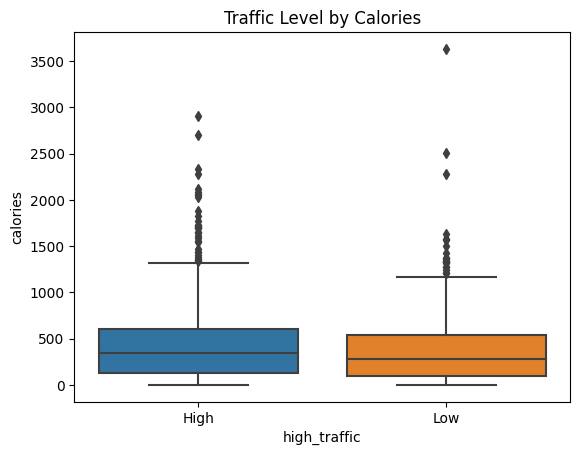

In [109]:
sns.boxplot(x = "high_traffic", y="calories", data=df)
plt.title("Traffic Level by Calories")
plt.show()

In [111]:
df.value_counts()

recipe  calories     carbohydrate  sugar      protein     category       servings  high_traffic
1       435.939196   35.069676     9.046547   24.149296   Pork           6         High            1
637     2029.330000  25.080000     0.610000   54.000000   One Dish Meal  1         High            1
625     68.540000    7.550000      17.680000  0.930000    Beverages      4         Low             1
626     113.120000   87.560000     16.960000  1.550000    Breakfast      2         High            1
627     544.010000   39.290000     1.750000   2.300000    Chicken        6         High            1
                                                                                                  ..
320     409.030000   71.580000     5.730000   125.660000  Chicken        2         High            1
321     31.750000    16.710000     1.020000   23.140000   Breakfast      1         Low             1
322     76.210000    91.250000     6.120000   3.270000    Dessert        4         High         

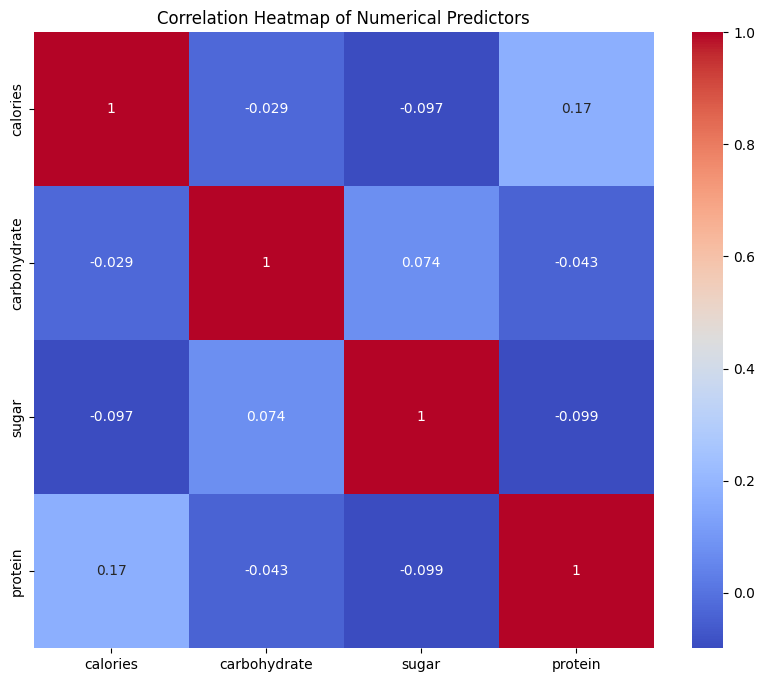

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['calories', 'carbohydrate', 'sugar', 'protein']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Predictors")
plt.show()

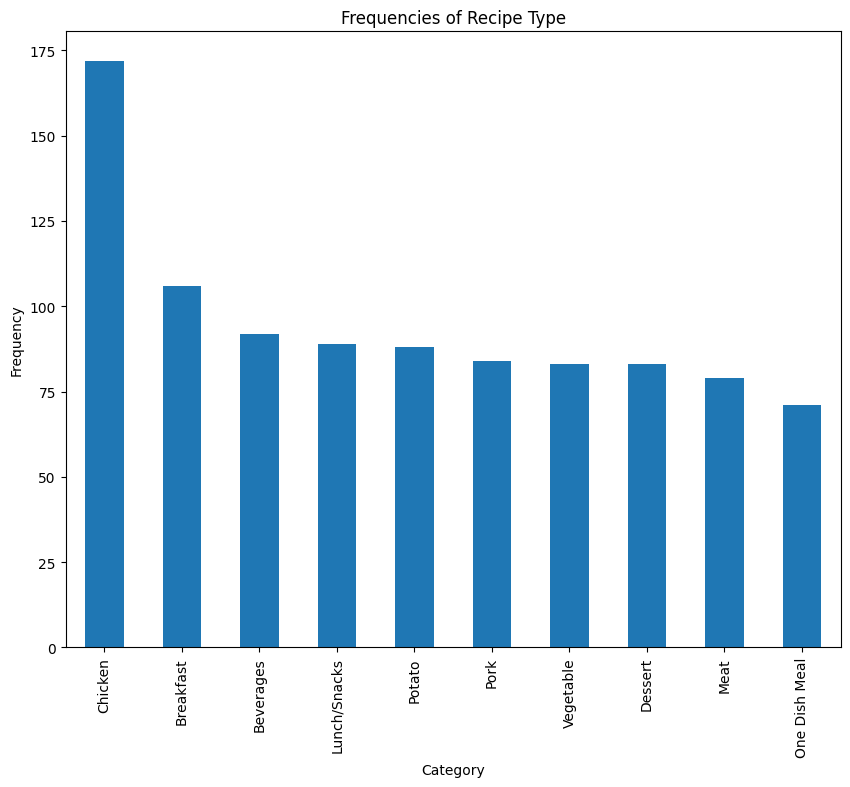

In [113]:
plt.figure(figsize=(10, 8))
df['category'].value_counts().plot(kind='bar')
plt.ylabel("Frequency")
plt.xlabel("Category")
plt.title("Frequencies of Recipe Type")
plt.show()

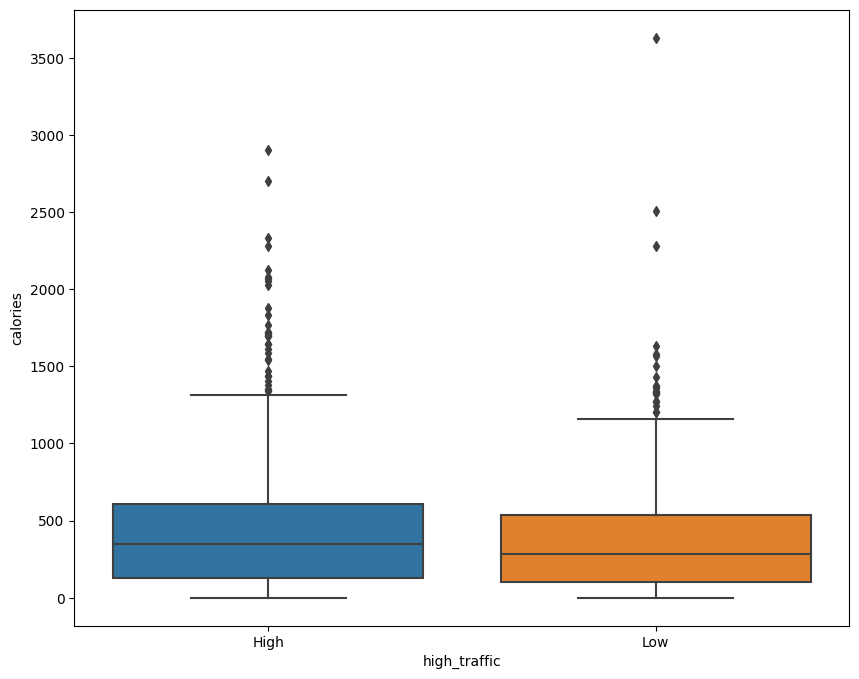

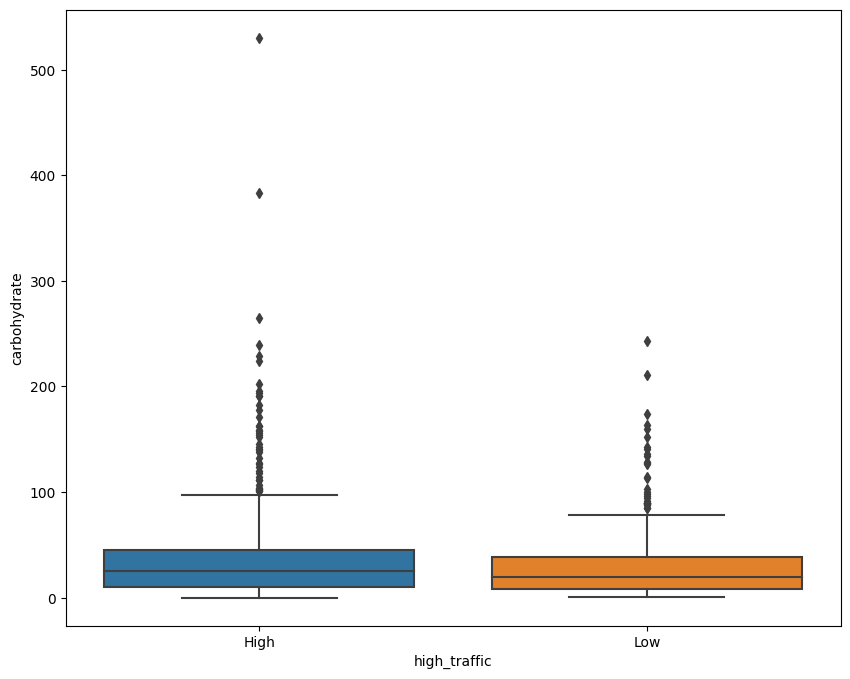

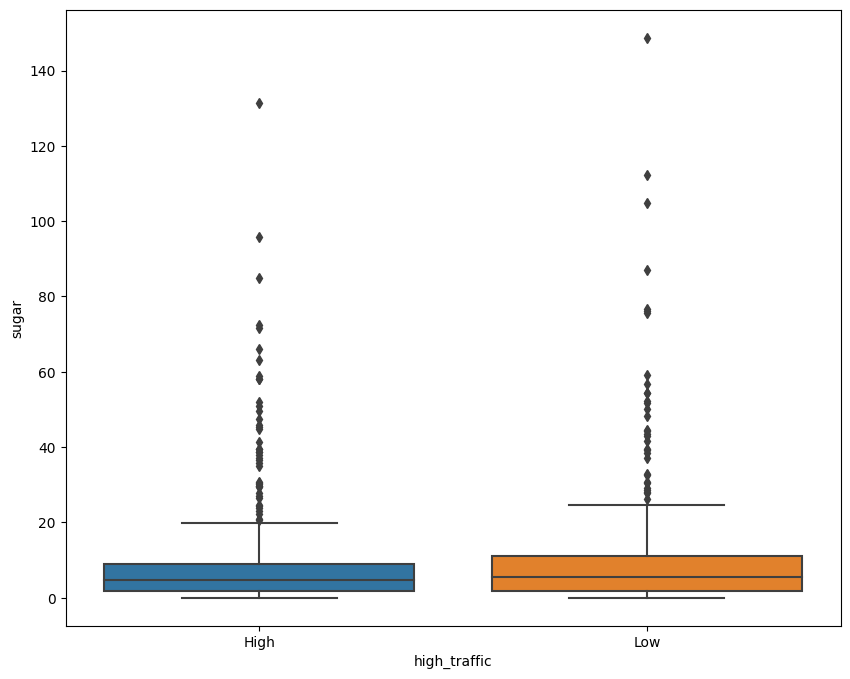

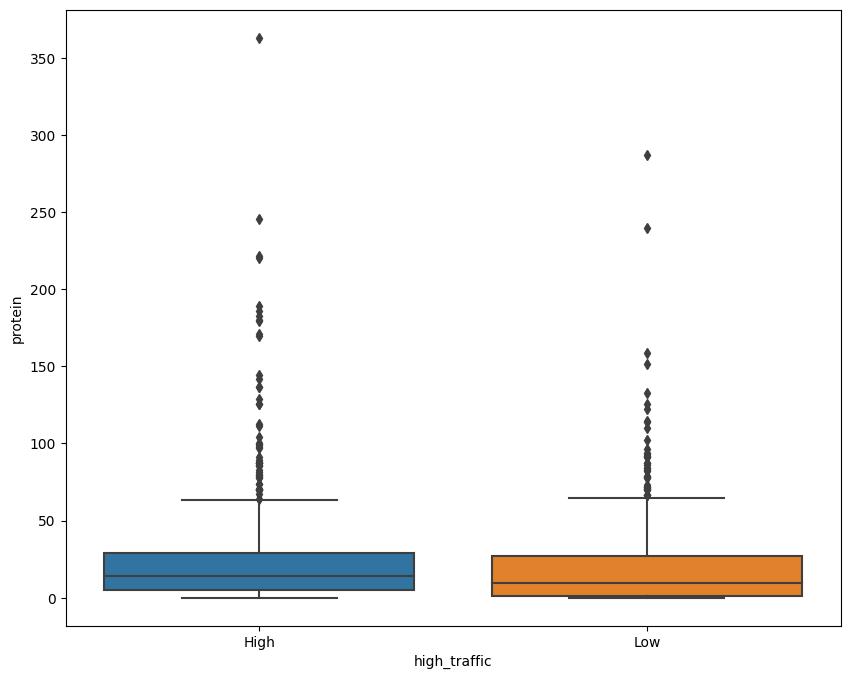

In [114]:
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
for col in numeric_columns:
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='high_traffic', y=col, data=df)
    plt.show()

# Model Development

In order to predict whether or not a recipe will be high traffic or not, we need to select methods that are good at predicting binary outcomes based on the values of the predictor variables, so I will use Logistic Regression as a baseline model and a Support Vector Classifier as a comparison model. Logistic Regression models are great binary classification models because they are simple, easy to implement and interpretable. It is a probabalistic method, meaning it predicts a new data point to belong to the class that it has the highest probability of being. I will compare that model with a Support Vector Classifier, which separates the two classes with a linear boundary. It can handle more complex relationships between variables and isn't prone to overfitting, which is good since the training set is large. 

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Preprocessing
X = df.drop(columns=['high_traffic'])
y = df['high_traffic'].replace({'High': 1, 'Low': 0})

# One-hot encoding for categorical variables and scaling for numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']),
        ('cat', OneHotEncoder(), ['category'])
    ])

X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)

# Support Vector Classifier
complex_model = SVC()
complex_model.fit(X_train, y_train)
complex_model_predictions = complex_model.predict(X_test)

## Model Evaluation

In [128]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_predictions))
print("Support Vector Classifier Classification Report:")
print(classification_report(y_test, complex_model_predictions))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68        77
           1       0.78      0.81      0.80       113

    accuracy                           0.75       190
   macro avg       0.74      0.74      0.74       190
weighted avg       0.75      0.75      0.75       190

Support Vector Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        77
           1       0.77      0.84      0.80       113

    accuracy                           0.75       190
   macro avg       0.75      0.73      0.74       190
weighted avg       0.75      0.75      0.75       190



Overall, these two models performed extremely similar, with lots of metrics being close to one another. There is nothing sticking out as terrible for either of these models, though the accuracy is a little lower than optimal.

In [123]:
print("Logistic Regression Accuracy: ", accuracy_score(y_test, log_reg_predictions))
print("SVC Accuracy: ", accuracy_score(y_test, complex_model_predictions))

Logistic Regression Accuracy:  0.7526315789473684
SVC Accuracy:  0.7526315789473684


In [124]:
print(log_reg.coef_[0])
print(len(log_reg.coef_[0]))

[ 0.01549909  0.10890329 -0.1366825   0.07842394  0.02483229 -2.85332109
 -1.4290548  -1.08460691  0.09752499 -0.11878012  0.0727651   0.01085648
  1.41925548  1.63727241  2.2477696 ]
15


In [125]:
encoded_df = pd.get_dummies(df, columns=['category'])

feature_names = encoded_df.columns.tolist()
feature_names.remove('high_traffic')
feature_names.remove("recipe")

coefficients = log_reg.coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Show top features sorted by the absolute value of their coefficient
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
top_features = coef_df.sort_values('abs_coefficient', ascending=False)

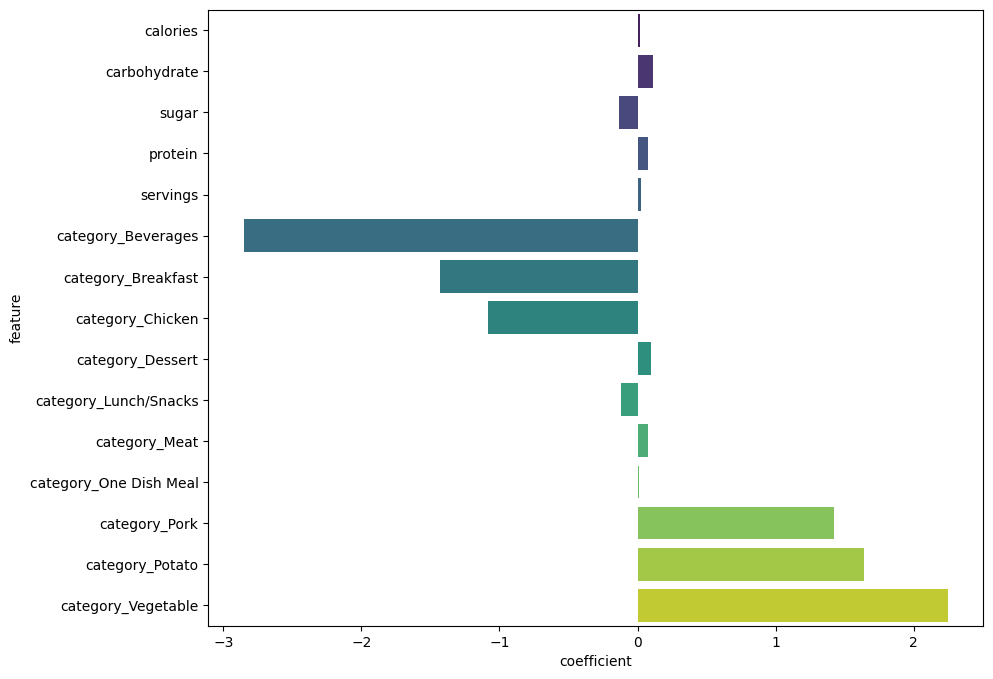

In [126]:
plt.figure(figsize=(10, 8))

# Create a bar plot of the coefficients (sorted by absolute value)
sns.barplot(data=coef_df, x='coefficient', y='feature', palette="viridis")

# Show the plot
plt.show()

Clearly, beverages, breakfast, and chicken recipes do not lead to high traffic whereas pork, potato, and vegetable recipes do. If Tasty Bytes focuses more on the latter categories and reduce focus on the former then they will likely increase their traffic, which is ultimately their goal.

# Business Metrics

A good metric to measure the models is accuracy, which is the proportion of correctly predicted traffic based on the recipe. The target of building these models was to correctly predict high traffic recipes 80% of the time. These models are not quite there in terms of their accuracy (75.26% for Logisitc Regression and 75.26% for Support Vector Classifier) but they are pretty close, all things considered. It is possible there is a better model such as Random Forest or Neural Networks that could provide better accuracy but if we get back to Tasty Bytes and the increased accuracy is very important to them we can adjust.

# Summary

After applying machine learning methods to Tasty Bytes' data, I recommend for now that we use the models to make decisions on which recipes to put on the website, since the accuracy isn't too far off from the desired level. From there we can continue to collect data and make better models which may include choosing a different approach and tuning hyperparameters (e.g. Regularization). Also, if they want more traffic they should focus on Pork, Potato, and Vegetable recipes, and scale back on Beverage, Breakfast, and Chicken recipes. It seems that people are more into dinner-style recipes opposed to breakfast, lunch and drink recipes.